# The QR Decomposition 

The $QR$ decomposition is a fundamentally important matrix factorization. It
is straightforward to implement, is numerically stable, and provides the 
basis of several important algorithms. In this lab we explore several 
ways to produce the QR decomposition and implement a few immediate 
applications.

The QR decomposition of a matrix $A$ is a factoration 

$$A =QR$$ 

where $Q$ has orthonormal columns and $R$ is upper triangular. Every $m \times n$
matrix $A$ of rank $n \leq m$ has a QR decomposition, with two main forms. 

- Reduced QR: Q is $m \times n$, R is $n \times n$, and the columns $\{q_j\}_{j=1}^n$ 
of Q form an orthonormal basis of $A$ 

-Full QR: Q is $m \times m$, R is $m \times n$. In this case, the columns
$\{q_j\}_{j=1}^m$ of Q form an orthonormal basis for all of $F^m$, and the last $m-n$ rows of R only contain zeros. 

We distinguish between these two forms by writing $\hat{Q}$ and $\hat{R}$
for reduced decomposition and Q and R for the full decomposition. 

![QR](../images/QR-decomposition.png)

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## QR via Gram-Schmidt 

Consider the Gram-Schmidt procedure, with  the vectors to be considered 
in the process as columns of the matrix $A$. That is 

$$
A = \begin{bmatrix}
\begin{array}{c|c|c|c}
a_1 & a_2 & \cdots & a_n
\end{array}
\end{bmatrix}
$$

Then, 

\begin{aligned}
u_1 = a_1, & \quad e_1 = \frac{u_1}{||u_1||} \\ 
u_2 = a_2 - <a_2, e_1> e_1, & \quad e_2 =  \frac{u_2}{||u_2||} \\
\vdots 
\end{aligned}

The  resulting QR factorization is 

$$
A = \begin{bmatrix}
\begin{array}{c|c|c|c}
a_1 & a_2 & \cdots & a_n
\end{array} 
\end{bmatrix} = \begin{bmatrix}
\begin{array}{c|c|c|c}
e_1 & e_2 & \cdots & e_n
\end{array} 
\end{bmatrix}  \begin{bmatrix}
a_1 \cdot e_1 & a_2 \cdot e_1, & \cdots & a_n \cdot e_1 \\
0 & a_2 \cdot e_2 & \cdots & a_n \cdot e_2 \\
\vdots & 
\end{bmatrix}
$$

With the above formula, one could do QR calculation easily by:

- normalize each columns for Q 
- calcualte each element for R with dot production 

## Modified Gram-Schmidt 

If the columns of $A$ are close to being linearly dependent, the classical Gram-Schmidt algorithm often produces a set of vectors $\{q_j\}_{j=1}^n$ that 
are not  even close to orthonormal due to __rounding errors__. The _modified Gram-Schmidt algorithm_ is a slight variant of the classical algorithm which
more consistently produces a set of vectors that are “very close” to orthonormal.

In [26]:
def modified_gram_schmidt(A: np.ndarray, reduced=False) -> np.ndarray:
    """
    Modified gram schmidt 
    """
    m, n = A.shape
    Q = A.copy()
    R = np.zeros_like(A)
    # iterate over columns 
    for i in range(n):
        # calculate the norm of each column 
        # assign it to the diagonal element of R
        R[i, i] = sp.linalg.norm(Q[:, i])
        # normalize the ith column of Q 
        Q[:, i] = Q[:, i]/R[i, i]
        for j in range(i+1, n):
            # dot production for each element of R
            # fix row i and iterate over columns (upper triangle)
            R[i, j] = np.dot(Q[:, i], Q[:, j])
            Q[:, j] = Q[:, j] - R[i, j] * Q[:, i]
    
    if reduced:
        R=R[:n, :n]

    return Q, R

In [6]:
np.random.seed(789)
A = np.random.random((6, 4))
A

array([[0.32333482, 0.23024711, 0.79377887, 0.62441968],
       [0.97541047, 0.75888589, 0.01062005, 0.02472696],
       [0.11104001, 0.53814938, 0.04545734, 0.55157035],
       [0.72836505, 0.29837837, 0.73311522, 0.64052568],
       [0.22060971, 0.12711688, 0.32747317, 0.41494326],
       [0.13789786, 0.59117679, 0.37050016, 0.59592555]])

In [21]:
 # use model='economic' for reduced QR
Q, R = sp.linalg.qr(A, mode='economic') 
print(A.shape, Q.shape, R.shape)

(6, 4) (6, 4) (4, 4)


In [17]:
# verify R is upper triangular 
np.allclose(np.triu(R), R)

True

In [18]:
# verify Q is orthonormal 
np.allclose(Q.T @ Q, np.identity(4))

True

In [19]:
np.allclose(Q @ R, A)

True

In [27]:
# test the function
Q, R = modified_gram_schmidt(A, reduced=True)
print(A.shape, Q.shape, R.shape)

(6, 4) (6, 4) (4, 4)


In [28]:
R

array([[1.29093027, 0.93058617, 0.71992524, 0.71848638],
       [0.        , 0.71218958, 0.03473689, 0.54327131],
       [0.        , 0.        , 0.94590276, 0.85749941],
       [0.        , 0.        , 0.        , 0.2926566 ]])

In [29]:
np.allclose(Q @ R, A)

True

The special structures of Q and R immediately provide some simple applications.
For instance, we could calcualte the determinant 

$$det(A) = det(Q)det(R)$$

In [33]:
def absolute_det(A):
    Q, R = modified_gram_schmidt(A, reduced=True)
    return np.abs(np.diag(R).prod())

In [34]:
absolute_det(A)

0.254509041280185

The LU decomposition is usually the matrix factorization of choice to solve the linear system $Ax = b$ because the triangular structures of L and U facilitate forward and backward substitution. However, the QR decomposition avoids the potential numerical issues that come with Gaussian elimination.

For $Ax = b$ we have

$$QRx = b \quad \to Rx = Q^Tb$$

In [37]:
def backward_substitution(U, y):
    """
    Doing backward substitution 
    """
    m, n = U.shape
    x = np.zeros_like(y)
    
    x[-1] = y[-1]/U[-1, -1]
    
    for i in range(m-2, -1, -1):
        x[i] = (y[i]-np.dot(U[i, i:], x[i:])) / U[i, i]
        
    return x 

In [38]:
def solve_with_qr(A, b):
    Q, R = modified_gram_schmidt(A, reduced=True)
    y = Q.T @ b 
    x = backward_substitution(R, y)

    return x 

In [39]:
A = np.array([[1, 4, 5], [6, 8, 22], [32, 5., 5]])
b = np.array([1, 2, 3.])
solve_with_qr(A, b)

array([ 0.05614973,  0.25935829, -0.01871658])

## Householder Transformations

For a nonzero vector $v$, we can have the projection of $x$ onto $v$  

$$\text{proj}_v (x)= \frac{v}{||v||^2} <v, x>$$

We define $x$'s residual as the projection of $x$ onto $v^{\perp}$

$$\text{proj}_{v^{\perp}}(x) = x - \text{proj}_v (x) = x - \frac{v}{||v||^2} <v, x>$$

The orthogonal complement of a nonzero vector $v \in R^n$ is the set of all 
vectors $x \in R^n$ that are orthogonal to $v$, denoted 

$$v^{\perp} = \{ x\in R^n | <x, v>  =0 \} $$

A Householder transformation reflects the vector $x$ across the orthogonal 
complement $v^{\perp} $, in essence moving twice as far as the projection. 

A _Householder transformation_ is a linear transformation that reflects a vector
$x$ across the orthogonal complement $v^{\perp}$ for some special $v$. 

![householder-matrix](https://i.stack.imgur.com/wPH2K.jpg)

The matrix representation of the Householder transformation corresponding to
$v$ is given by 

$$H_v(x) = x - 2\text{proj}_v(x) =\left( I - 2 \frac{v v^T}{v^T v} \right)x $$

$$H_v = I - 2 \frac{v v^T}{v^T v}$$

## Catastrophic cancellation

In numerical analysis, _catastrophic cancellation_ is the phenomenon that 
subtracting good approximations to two nearby numbers may yield a very 
bad approximation to the difference of the original numbers.

In [2]:
x = 1.48234
y = 1.48235
x_dbl = np.float64(x)
y_dbl = np.float64(y)
diff_dbl = x_dbl-y_dbl
print(repr(diff_dbl))

-1.0000000000065512e-05


In [3]:
x_sng = np.float32(x)
y_sng = np.float32(y)
diff_sng = x_sng-y_sng

print(diff_sng)

-1.001358e-05


Now we will calculate 

$$f(x) = \frac{1-\sqrt{1-t^2}}{t}, \quad t = \exp(-\pi x)$$

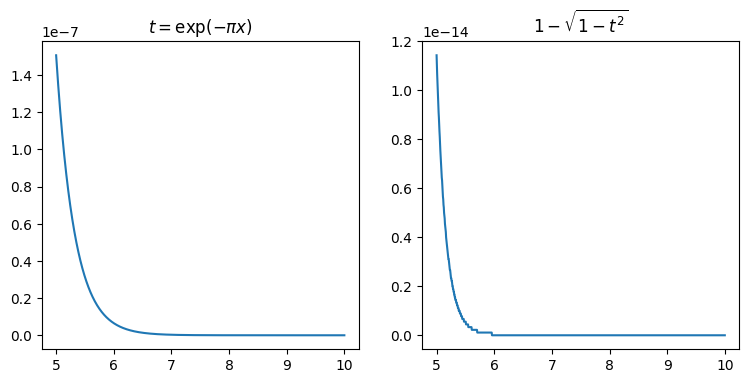

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
xx = np.linspace(5, 10, 1000)
t = np.exp(-np.pi*xx)
axes[0].plot(xx, t);
axes[0].set_title(r'$t = \exp(-\pi x)$');
axes[1].plot(xx, 1-np.sqrt(1-t**2))
axes[1].set_title(r'$1-\sqrt{1-t^2}$');

In [9]:
# https://scicomp.stackexchange.com/questions/14795/how-to-avoid-catastrophic-cancellation-in-python-function
def func(x):
    t = np.exp(-np.pi*x)
    y = 1/t*(1-np.sqrt(1-t**2))
    return y

In [10]:
def func2(x):
    t = np.exp(-np.pi*x)
    y = 1/t*(1-np.sqrt(1-t**2))
    y = y * (1-np.sqrt(1-t**2)) / (1-np.sqrt(1-t**2))
    return y

/tmp/ipykernel_127308/1188341579.py:4: RuntimeWarning: invalid value encountered in divide
  y = y * (1-np.sqrt(1-t**2)) / (1-np.sqrt(1-t**2))


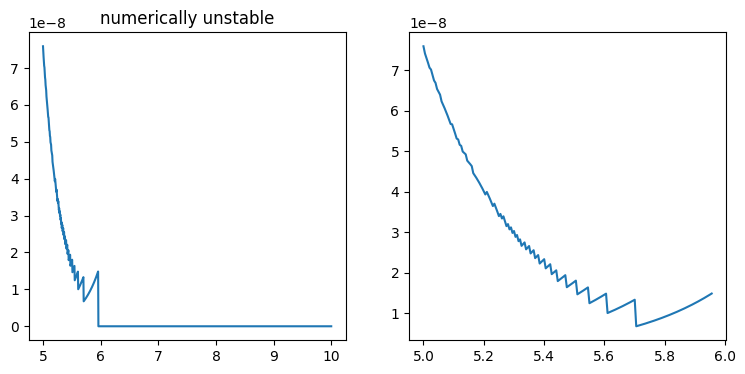

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
xx = np.linspace(5, 10, 1000)
axes[0].plot(xx, func(xx))
axes[0].set_title("numerically unstable")
axes[1].plot(xx, func2(xx));

Now, we will transfer the function to numerically stable one:

$$f(x) = \frac{1-\sqrt{1-t^2}}{t} \times  \frac{1+\sqrt{1-t^2}}{1+\sqrt{1-t^2}} = \frac{t}{1+ \sqrt{1-t^2}} $$

In [21]:
def func3(x):
     t = np.exp(-np.pi*x)
     y = t/(1+np.sqrt(1-t**2))
     return y

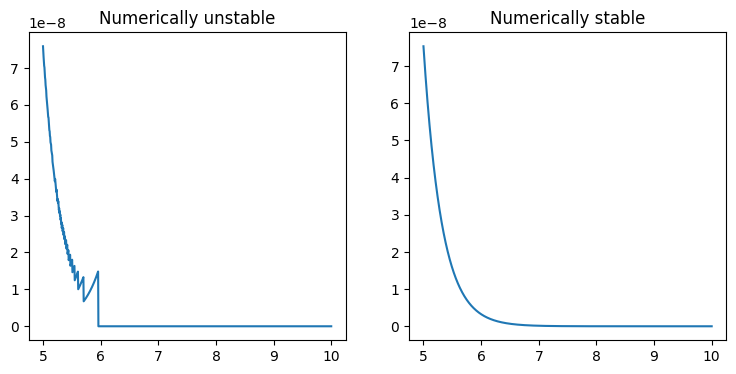

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
xx = np.linspace(5, 10, 1000)
axes[0].plot(xx, func(xx))
axes[0].set_title("Numerically unstable")
axes[1].plot(xx, func3(xx))
axes[1].set_title("Numerically stable");

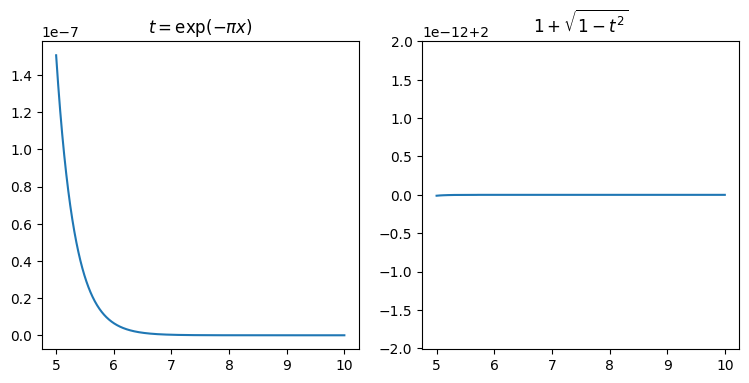

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
xx = np.linspace(5, 10, 1000)
t = np.exp(-np.pi*xx)
axes[0].plot(xx, t);
axes[0].set_title(r'$t = \exp(-\pi x)$');
axes[1].plot(xx, 1+np.sqrt(1-t**2))
axes[1].set_title(r'$1+\sqrt{1-t^2}$');

## Householder Triangularization

The Householder algorithm uses Householder transformations for the orthonormal 
transformations in the QR decomposition process described on the previous page.

## QR via Householder

There is another way to construct $QR$ decomposition as 

$$Q_n \cdots Q_2 Q_1 A = R$$